# Time-Domain Relaxation Validation

Validate RheoJAX relaxation fits on the PyVisco time-domain dataset.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Fit relaxation modulus data and compare Prony vs fractional models.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-07 17:46:11,205:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyvisco' / 'time_master'
relax_df = pd.read_csv(DATA_DIR / 'time_user_master.csv')

relax_clean = relax_df.iloc[1:].astype(float)
t = relax_clean['t'].to_numpy()
E_t = relax_clean['E_relax'].to_numpy()

data = RheoData(x=t, y=E_t, x_units='s', y_units='MPa', domain='relaxation')
print(data)


RheoData(x=array([2.8176e-03, 2.5827e-02, 5.5724e-02, 8.9250e-02, 1.2278e-01,
       1.5215e-01, 1.8103e-01, 2.1337e-01, 2.4577e-01, 2.7918e-01,
       3.1173e-01, 3.4513e-01, 3.7754e-01, 4.1103e-01, 4.4346e-01,
       4.7695e-01, 5.0937e-01, 5.4287e-01, 5.7526e-01, 6.0880e-01,
       6.4121e-01, 6.7472e-01, 7.0711e-01, 7.4063e-01, 9.3044e-01,
       1.1662e+00, 1.4011e+00, 1.6631e+00, 1.9252e+00, 2.1966e+00,
       2.4588e+00, 2.7300e+00, 2.9922e+00, 3.2635e+00, 3.5256e+00,
       3.7965e+00, 4.0590e+00, 4.3273e+00, 4.5926e+00, 4.8585e+00,
       5.1262e+00, 5.3888e+00, 5.6595e+00, 5.9218e+00, 6.1930e+00,
       7.2434e+00, 8.9706e+00, 1.0696e+01, 1.2402e+01, 1.3982e+01,
       1.5550e+01, 1.7197e+01, 1.8912e+01, 2.0593e+01, 2.2271e+01,
       2.3988e+01, 2.5713e+01, 2.7440e+01, 2.9108e+01, 3.0835e+01,
       3.2562e+01, 3.4242e+01, 3.5957e+01, 3.7681e+01, 4.1493e+01,
       5.5348e+01, 6.9218e+01, 8.3025e+01, 9.6886e+01, 1.1076e+02,
       1.2459e+02, 1.3843e+02, 1.5232e+02, 1.6615e+

## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(t, E_t, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, E_t)

fm = FractionalMaxwellModel()
fm.fit(t, E_t, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(E_t, fm_pred)


print(f"Generalized Maxwell R^2: {gm_r2:.4f}")
print(f"Fractional Maxwell R^2:   {fm_r2:.4f}")


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.296221s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=4.790065e+07 | time=1.296s | final_gradient_norm=1566957452.1387854


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.295135s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=4.790065e+07 | time=0.295s | final_gradient_norm=1566957452.1387854


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.929725s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=4.726767e+07 | time=0.930s | final_gradient_norm=4301842872.211341


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.944443s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=4.726774e+07 | time=0.944s | final_gradient_norm=260843471.5355467


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.939137s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=4.727053e+07 | time=0.939s | final_gradient_norm=2379781497.1322446


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.855328s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=4.727792e+07 | time=0.855s | final_gradient_norm=50171392.943035275


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.497897s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=2 | final_cost=4.733564e+07 | time=0.498s | final_gradient_norm=0.08726020354349318


Element minimization: reducing from 6 to 1 modes


Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.303811s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.616982e+05 | time=1.304s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Generalized Maxwell R^2: 0.4344
Fractional Maxwell R^2:   -22784.2528


## Plot relaxation fits

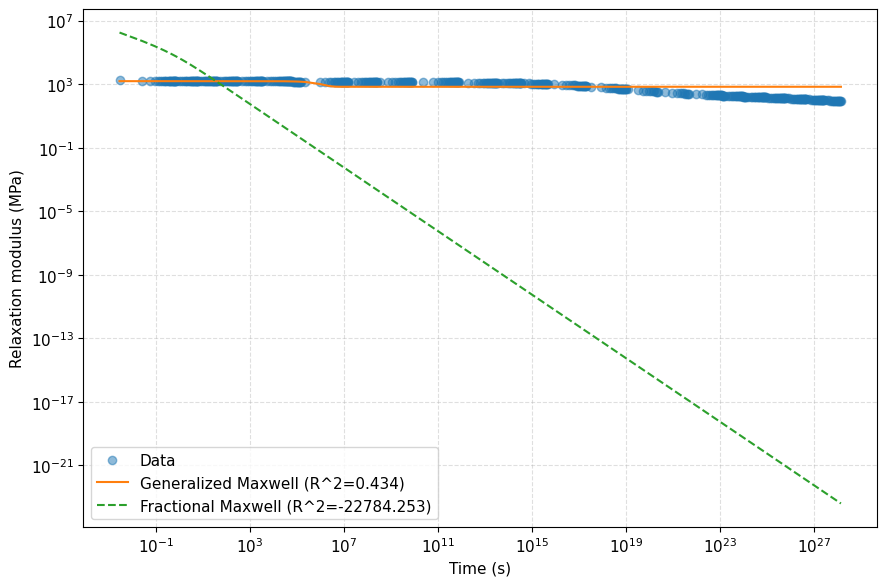

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t, E_t, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'Generalized Maxwell (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional Maxwell (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (MPa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.274128s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=21 | final_cost=4.733564e+07 | time=0.274s | final_gradient_norm=9.961558550175043


Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.666327s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.616982e+05 | time=0.666s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.434), ('fm', -22784.253)]


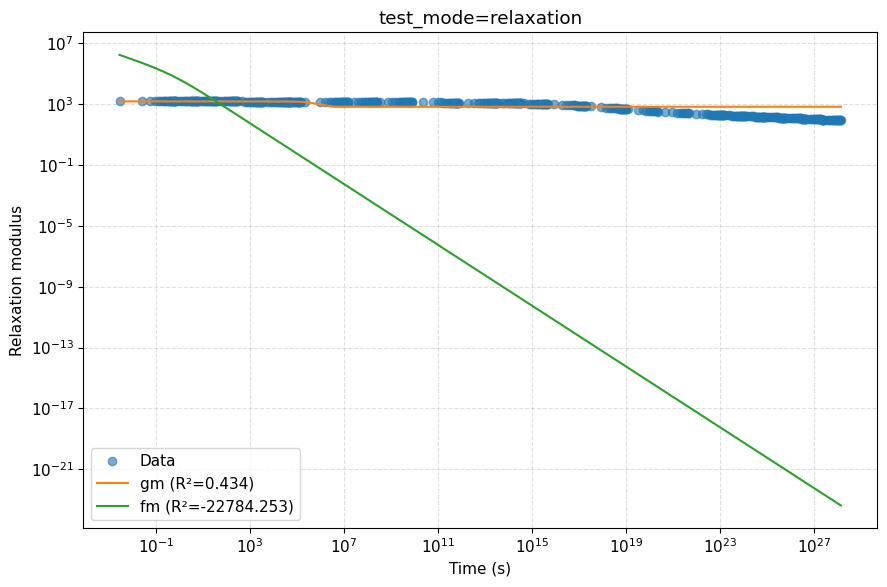

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<37:25,  1.78it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   7%|▋         | 292/4000 [00:00<00:06, 591.30it/s, 3 steps of size 1.56e+00. acc. prob=0.78]

warmup:  18%|█▊        | 722/4000 [00:00<00:02, 1424.09it/s, 3 steps of size 1.18e+00. acc. prob=0.79]

sample:  29%|██▉       | 1162/4000 [00:00<00:01, 2145.71it/s, 7 steps of size 6.31e-01. acc. prob=0.93]

sample:  40%|███▉      | 1590/4000 [00:00<00:00, 2692.55it/s, 15 steps of size 6.31e-01. acc. prob=0.91]

sample:  50%|█████     | 2011/4000 [00:01<00:00, 3099.43it/s, 3 steps of size 6.31e-01. acc. prob=0.91] 

sample:  61%|██████    | 2441/4000 [00:01<00:00, 3429.62it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample:  72%|███████▏  | 2875/4000 [00:01<00:00, 3687.61it/s, 3 steps of size 6.31e-01. acc. prob=0.91]

sample:  83%|████████▎ | 3307/4000 [00:01<00:00, 3866.72it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample:  93%|█████████▎| 3726/4000 [00:01<00:00, 3701.17it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2571.51it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 286/4000 [00:00<00:01, 2857.06it/s, 15 steps of size 3.25e-01. acc. prob=0.78]

warmup:  18%|█▊        | 722/4000 [00:00<00:00, 3736.64it/s, 7 steps of size 9.53e-01. acc. prob=0.79] 

sample:  29%|██▊       | 1143/4000 [00:00<00:00, 3950.25it/s, 7 steps of size 5.22e-01. acc. prob=0.92]

sample:  39%|███▉      | 1563/4000 [00:00<00:00, 4048.65it/s, 7 steps of size 5.22e-01. acc. prob=0.93]

sample:  49%|████▉     | 1979/4000 [00:00<00:00, 4085.63it/s, 15 steps of size 5.22e-01. acc. prob=0.93]

sample:  60%|█████▉    | 2397/4000 [00:00<00:00, 4114.11it/s, 7 steps of size 5.22e-01. acc. prob=0.93] 

sample:  70%|███████   | 2810/4000 [00:00<00:00, 4118.57it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

sample:  81%|████████  | 3223/4000 [00:00<00:00, 4119.22it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

sample:  91%|█████████ | 3636/4000 [00:00<00:00, 4120.10it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4038.59it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 281/4000 [00:00<00:01, 2808.79it/s, 3 steps of size 1.87e+00. acc. prob=0.78]

warmup:  18%|█▊        | 710/4000 [00:00<00:00, 3674.77it/s, 7 steps of size 8.43e-01. acc. prob=0.79]

sample:  29%|██▊       | 1148/4000 [00:00<00:00, 3992.12it/s, 7 steps of size 5.77e-01. acc. prob=0.91]

sample:  39%|███▉      | 1569/4000 [00:00<00:00, 4077.31it/s, 3 steps of size 5.77e-01. acc. prob=0.91]

sample:  50%|████▉     | 1994/4000 [00:00<00:00, 4138.47it/s, 7 steps of size 5.77e-01. acc. prob=0.91]

sample:  60%|██████    | 2418/4000 [00:00<00:00, 4172.06it/s, 3 steps of size 5.77e-01. acc. prob=0.91]

sample:  71%|███████   | 2842/4000 [00:00<00:00, 4192.13it/s, 3 steps of size 5.77e-01. acc. prob=0.92]

sample:  82%|████████▏ | 3275/4000 [00:00<00:00, 4235.28it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

sample:  93%|█████████▎| 3701/4000 [00:00<00:00, 4239.57it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4116.21it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▊         | 349/4000 [00:00<00:01, 3489.06it/s, 3 steps of size 6.40e-01. acc. prob=0.79]

warmup:  20%|██        | 808/4000 [00:00<00:00, 4133.27it/s, 3 steps of size 4.22e-01. acc. prob=0.79]

sample:  31%|███       | 1223/4000 [00:00<00:00, 4137.88it/s, 7 steps of size 5.37e-01. acc. prob=0.94]

sample:  41%|████      | 1637/4000 [00:00<00:00, 4130.98it/s, 3 steps of size 5.37e-01. acc. prob=0.93]

sample:  51%|█████▏    | 2051/4000 [00:00<00:00, 4133.67it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  62%|██████▏   | 2469/4000 [00:00<00:00, 4147.24it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  72%|███████▏  | 2890/4000 [00:00<00:00, 4166.36it/s, 3 steps of size 5.37e-01. acc. prob=0.93]

sample:  83%|████████▎ | 3307/4000 [00:00<00:00, 4147.36it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  93%|█████████▎| 3732/4000 [00:00<00:00, 4176.91it/s, 3 steps of size 5.37e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4134.83it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>]], dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
